In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

pd.set_option('display.max_columns', 50)

In [ ]:
from fcapy.context import FormalContext
from fcapy.lattice import ConceptLattice

from fcapy.visualizer import LineVizNx
import matplotlib.pyplot as plt

import neural_lib as nl

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=Warning)

## Load dataset

In [4]:
df = pd.read_csv('data/train.csv')
print(df.shape)
df.head()

(159256, 24)


,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,fasting blood sugar,Cholesterol,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
0,0,55,165,60,81.0,0.5,0.6,1,1,135,87,94,172,300,40,75,16.5,1,1.0,22,25,27,0,1
1,1,70,165,65,89.0,0.6,0.7,2,2,146,83,147,194,55,57,126,16.2,1,1.1,27,23,37,1,0
2,2,20,170,75,81.0,0.4,0.5,1,1,118,75,79,178,197,45,93,17.4,1,0.8,27,31,53,0,1
3,3,35,180,95,105.0,1.5,1.2,1,1,131,88,91,180,203,38,102,15.9,1,1.0,20,27,30,1,0
4,4,30,165,60,80.5,1.5,1.0,1,1,121,76,91,155,87,44,93,15.4,1,0.8,19,13,17,0,1


In [5]:
features = df.drop(columns=['id','smoking']).columns
print(features)
print(len(features))

Index(['age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)',
       'eyesight(right)', 'hearing(left)', 'hearing(right)', 'systolic',
       'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride',
       'HDL', 'LDL', 'hemoglobin', 'Urine protein', 'serum creatinine', 'AST',
       'ALT', 'Gtp', 'dental caries'],
      dtype='object')
22


## Binning

In [6]:
# df['Gtp>500'].value_counts()

In [7]:
df_bin = pd.DataFrame()

df_bin['height=>165'] = df['height(cm)'] >= 165 
df_bin['height<165'] = df['height(cm)'] < 165

df_bin['weight>=65'] = df['weight(kg)'] >= 65
df_bin['weight<65'] = df['weight(kg)'] < 65

df_bin['hemoglobin>=14.5'] = df['hemoglobin'] >= 14.5
df_bin['hemoglobin<14.5'] = df['hemoglobin'] < 14.5


df_bin['smoking'] = df['smoking'] == 1

df_bin.head(5)

,height=>165,height<165,weight>=65,weight<65,hemoglobin>=14.5,hemoglobin<14.5,smoking
0,True,False,False,True,True,False,True
1,True,False,True,False,True,False,False
2,True,False,True,False,True,False,True
3,True,False,True,False,True,False,False
4,True,False,False,True,True,False,True


In [8]:
df_bin['sample_id'] = np.arange(0, df_bin.shape[0], 1).astype(str)
df_bin['id'] = df_bin['sample_id'].apply(lambda x: 'h' + x)
df_bin.drop(columns=['sample_id'], inplace=True)
df_bin=df_bin.set_index('id')
df_bin.sample(n=1)

,height=>165,height<165,weight>=65,weight<65,hemoglobin>=14.5,hemoglobin<14.5,smoking
id,,,,,,,
h93777,False,True,True,False,True,False,True


# Step 1. Build Monotone Concept Lattice
Put binarized data in FormalContext and compute monotone ConceptLattice

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, recall_score, accuracy_score, classification_report, roc_auc_score


y_feat = 'smoking'
df_train, df_test = train_test_split(df_bin, train_size=0.7, random_state=0)

print(df_train.shape[0], df_test.shape[0])

X_train, y_train = df_train.drop(y_feat, axis=1), df_train[y_feat]
X_test, y_test = df_test.drop(y_feat, axis=1), df_test[y_feat]

X_train.sample(n=1)

111479 47777


,height=>165,height<165,weight>=65,weight<65,hemoglobin>=14.5,hemoglobin<14.5
id,,,,,,
h39556,True,False,True,False,True,False


In [10]:
K_train = FormalContext.from_pandas(X_train)
K_train

FormalContext (111479 objects, 6 attributes, 334437 connections)
       |height=>165|height<165|weight>=65|weight<65|hemoglobin>=14.5|hemoglobin<14.5|
h54520 |          X|          |         X|         |               X|               |
h134197|          X|          |         X|         |               X|               |
h135603|          X|          |         X|         |               X|               |
h93935 |          X|          |         X|         |               X|               |
h11867 |          X|          |         X|         |               X|               |
h33796 |           |         X|          |        X|               X|               |
h118830|          X|          |         X|         |               X|               |
h45039 |          X|          |         X|         |                |              X|
h71465 |          X|          |         X|         |               X|               |
h40914 |          X|          |         X|         |               X|      

In [11]:
%%time 
L = ConceptLattice.from_context(K_train, is_monotone=True)
len(L)

CPU times: total: 7.75 s
Wall time: 7.75 s


28

In [17]:
arr = []

for i, c in enumerate(L):
    y_preds = np.zeros(K_train.n_objects)
    y_preds[list(c.extent_i)] = 1
#     c.measures['f1_score'] = f1_score(y_train, y_preds)
#     c.measures['rocauc_score'] = roc_auc_score(y_train, y_preds)
#     c.measures['recall_score'] = recall_score(y_train, y_preds)
    
    arr.append([f1_score(y_train, y_preds),roc_auc_score(y_train, y_preds),recall_score(y_train, y_preds),])

In [19]:
stat = pd.DataFrame(arr, columns=['f1_score','rocauc_score','recall_score']).sort_values('rocauc_score',ascending=False)
# stat = pd.DataFrame([el.measures for el in L]).sort_values('rocauc_score',ascending=False)
stat

,f1_score,rocauc_score,recall_score
10,0.724254,0.724670,0.893753
9,0.716221,0.717677,0.874548
11,0.725722,0.713834,0.964941
12,0.704445,0.688378,0.938374
13,0.704690,0.686835,0.947380
14,0.702584,0.677997,0.974050
8,0.669199,0.668802,0.809529
19,0.617128,0.536292,0.955379
23,0.623439,0.535837,0.990891
16,0.608851,0.530842,0.927167


Select indices of the best concepts from the lattice

In [26]:
best_concepts = stat.index[:8]

assert len({g_i for c in L[best_concepts] for g_i in c.extent_i})==K_train.n_objects, "Selected concepts do not cover all train objects"

Construct neural network based on concept lattice

In [28]:
cn = nl.ConceptNetwork.from_lattice(L, best_concepts, sorted(set(y_train)))

Setup visuzalier for the architecture

In [29]:
vis = LineVizNx(node_label_font_size=14, node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes))+'\n\n')

In [30]:
set(df_test.columns)

{'height<165',
 'height=>165',
 'hemoglobin<14.5',
 'hemoglobin>=14.5',
 'smoking',
 'weight<65',
 'weight>=65'}

In [33]:
descr = {'height<165', 'weight<65'}

traced = cn.trace_description(descr, include_targets=False)

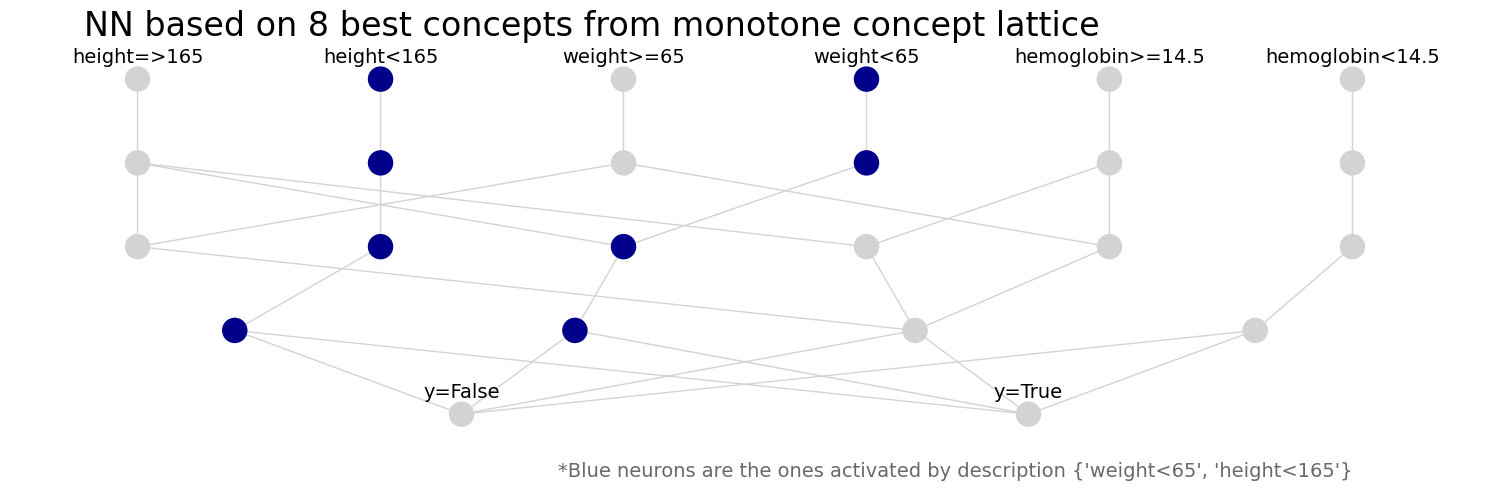

In [34]:
fig, ax = plt.subplots(figsize=(15,5))

vis.draw_poset(
    cn.poset, ax=ax, 
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes), only_new_attrs=True)+'\n\n',
    node_color=['darkblue' if el_i in traced else 'lightgray' for el_i in range(len(cn.poset))]
)
plt.title(f'NN based on 8 best concepts from monotone concept lattice', loc='left', x=0.05, size=24)

plt.text(max(vis.mover.posx), min(vis.mover.posy)-0.3, f'*Blue neurons are the ones activated by description {descr}', fontsize=14, ha='right', color='dimgray')

plt.subplots_adjust()
plt.tight_layout()
plt.savefig('nn_silly_baseline.png')
plt.show()

# Fit

In [35]:
cn.fit(X_train, y_train)

In [36]:
y_pred = cn.predict(X_test).numpy()
print('Class prediction', y_pred[:10])
y_proba = cn.predict_proba(X_test).detach().numpy()
print('Class prediction with probabilities', y_proba[:10])
print('True class', y_test.values[:10])

Class prediction [0 1 1 1 0 0 0 1 1 0]
Class prediction with probabilities [[0.9981103  0.00188969]
 [0.24329239 0.7567076 ]
 [0.24329239 0.7567076 ]
 [0.24329239 0.7567076 ]
 [0.9981103  0.00188969]
 [0.99509025 0.00490975]
 [0.9981103  0.00188969]
 [0.24329239 0.7567076 ]
 [0.24329239 0.7567076 ]
 [0.9981103  0.00188969]]
True class [False False  True  True  True  True False False  True False]


In [39]:
print('Recall score:', recall_score(y_test.values.astype('int'), y_pred))
print('F1     score:', f1_score(y_test.values.astype('int'), y_pred))
print()
print('ROC AUC score:', roc_auc_score(y_test.values.astype('int'), y_pred))

Recall score: 0.892631178345464
F1     score: 0.724296991102619

ROC AUC score: 0.7215435754188076


In [40]:
print('Accuracy score:', accuracy_score(y_test.values.astype('int'), y_pred))
print(classification_report(y_test.values.astype('int'), y_pred))

Accuracy score: 0.7010067605751722
              precision    recall  f1-score   support

           0       0.87      0.55      0.67     26756
           1       0.61      0.89      0.72     21021

    accuracy                           0.70     47777
   macro avg       0.74      0.72      0.70     47777
weighted avg       0.75      0.70      0.70     47777



Let us look at the fitted weights of edges

In [41]:
edge_weights = cn.edge_weights_from_network()

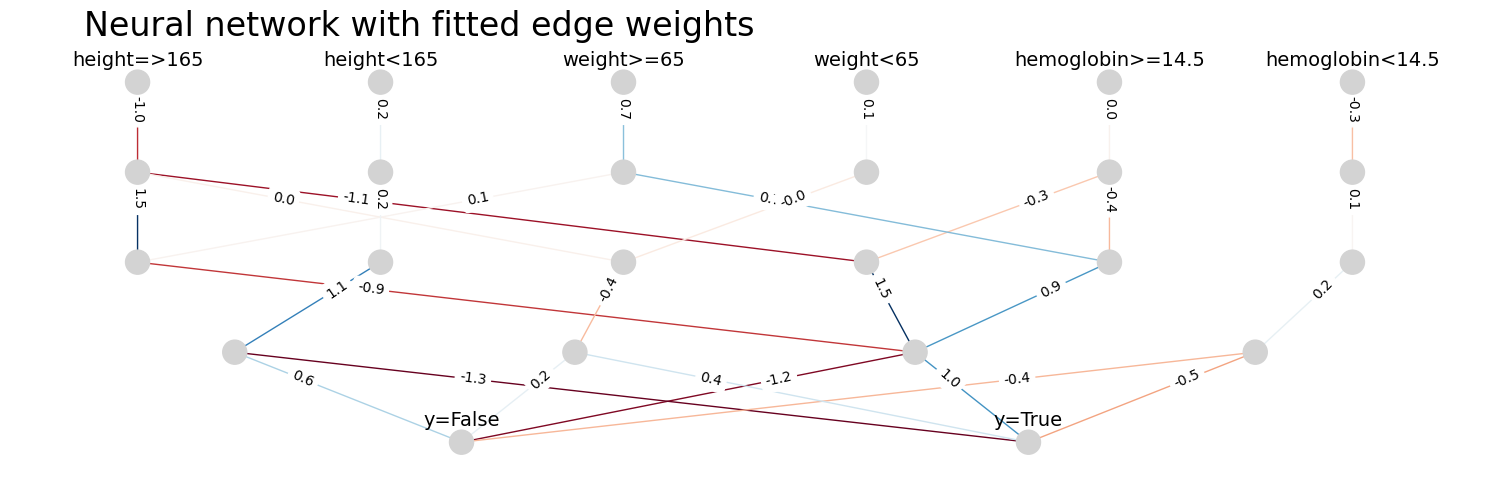

In [42]:
import networkx as nx

fig, ax = plt.subplots(figsize=(15,5))

vis.draw_poset(
    cn.poset, ax=ax, 
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes), only_new_attrs=True)+'\n\n',
    edge_color=[edge_weights[edge] for edge in cn.poset.to_networkx().edges],
    edge_cmap=plt.cm.RdBu,
)
nx.draw_networkx_edge_labels(cn.poset.to_networkx(), vis.mover.pos, {k: f"{v:.1f}" for k,v in edge_weights.items()}, label_pos=0.7)

plt.title('Neural network with fitted edge weights', size=24, x=0.05, loc='left')
plt.tight_layout()
plt.subplots_adjust()
plt.savefig('fitted_network_silly_baseline.png')
plt.show()

## Try Different n_epochs

In [55]:
# res = []

# for n in [10,100,300,700,1000,1200,1500,2000,2500]:
for n in [2700,3000,4000]:
    cn.fit(X_train, y_train, n_epochs = n)

    y_pred = cn.predict(X_test).numpy()
    y_proba = cn.predict_proba(X_test).detach().numpy()

    
    res.append([n, round(roc_auc_score(y_test.values.astype('int'), y_pred),4) ])
    
res

[[10, 0.5],
 [100, 0.5],
 [300, 0.5],
 [700, 0.5],
 [1000, 0.7148],
 [1200, 0.7215],
 [1500, 0.6694],
 [2000, 0.7215],
 [2500, 0.5],
 [2700, 0.5],
 [3000, 0.7215],
 [4000, 0.5]]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


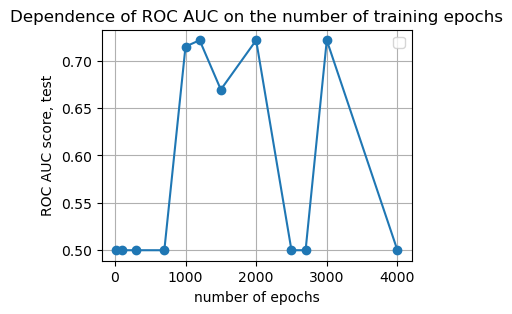

In [56]:
plt.figure(figsize=(4, 3))
plt.plot([point[0] for point in res], [point[1] for point in res], marker='o', linestyle='-', label='')
plt.title('Dependence of ROC AUC on the number of training epochs')
plt.xlabel('number of epochs')
plt.ylabel('ROC AUC score, test')
plt.grid()
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


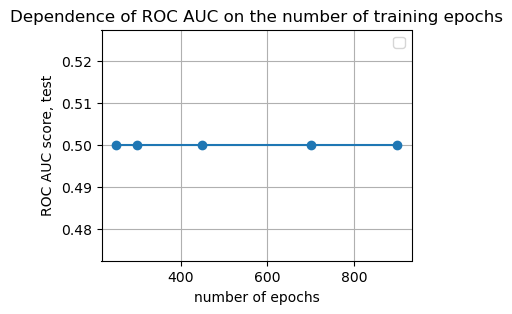

In [58]:
res = []

for n in [250,300,450,700,900]:
    cn.fit(X_train, y_train, n_epochs = n)

    y_pred = cn.predict(X_test).numpy()
    y_proba = cn.predict_proba(X_test).detach().numpy()

    
    res.append([n, round(roc_auc_score(y_test.values.astype('int'), y_pred),4) ])
    
plt.figure(figsize=(4, 3))
plt.plot([point[0] for point in res], [point[1] for point in res], marker='o', linestyle='-', label='')
plt.title('Dependence of ROC AUC on the number of training epochs')
plt.xlabel('number of epochs')
plt.ylabel('ROC AUC score, test')
plt.grid()
plt.legend()
plt.show()

## Trash

In [1]:
# import neural_lib2 as nl2
# from sparselinear import SparseLinear

In [ ]:
# ! pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118 --user
# ! pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.5.0+cpu.html

In [19]:
# ! pip install bitarray==2.7.5 --user

# L = ConceptLattice.from_context(K_train,algo='Sofia', is_monotone=True)
# len(L)

# ! pip show fcapy # 0.1.4 по состояни. на 7 дек

# !pip install fcapy==0.1.4.1